In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
tesla_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "tesla"]

In [7]:
tesla_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
3025,tesla,2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026
3026,tesla,2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027
3027,tesla,2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028
3028,tesla,2022-07-11,756.309998,759.190002,700.880005,703.030029,703.030029,33080400,3029


In [8]:
end_date = tesla_price['date'].iloc[-1]
end_date

'2022-07-12'

In [9]:
tesla_price['date'] = pd.to_datetime(tesla_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
tesla_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
tesla_price.set_index("date",inplace = True)

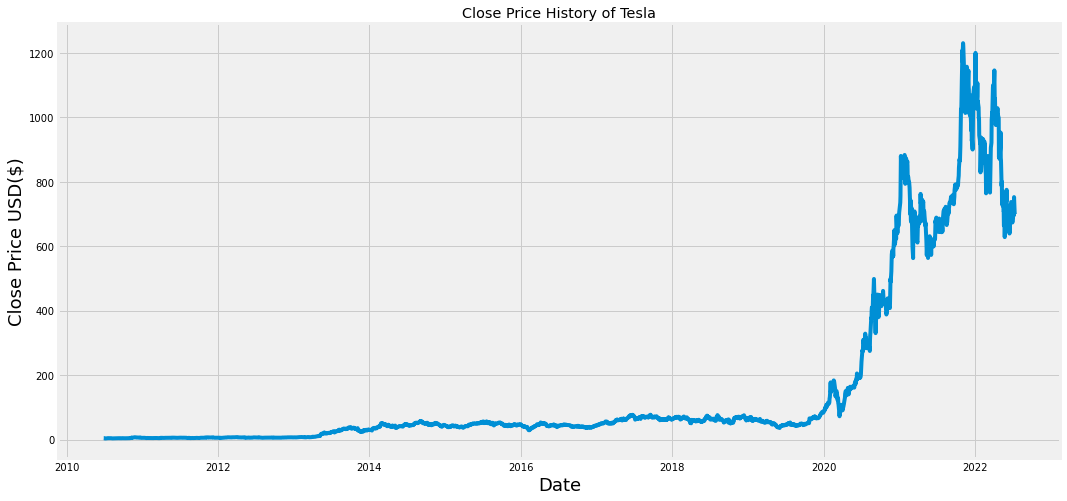

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(tesla_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = tesla_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((2424, 1), (606, 1))

In [17]:
train

,close
date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2020-02-07,149.613998
2020-02-10,154.255997
2020-02-11,154.876007


In [18]:
test

,close
date,
2020-02-14,160.005997
2020-02-18,171.679993
2020-02-19,183.483994
2020-02-20,179.882004
2020-02-21,180.199997
...,...
2022-07-06,695.200012
2022-07-07,733.630005
2022-07-08,752.289978


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.61066228],
       [0.57050745],
       [0.56739352]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(2424, 2424)

In [21]:
train_scaled.shape,test_scaled.shape

((2424, 1), (606, 1))

In [22]:
train_scaled

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.12367312],
       [0.12251721],
       [0.12850214]])

In [23]:
test_scaled

array([[0.1278549 ],
       [0.13737109],
       [0.14699327],
       [0.14405706],
       [0.14431628],
       [0.13335887],
       [0.12783533],
       [0.12439372],
       [0.10812309],
       [0.10632811],
       [0.11865824],
       [0.11896638],
       [0.11961687],
       [0.11554759],
       [0.11211412],
       [0.09654778],
       [0.10263378],
       [0.10082413],
       [0.0888119 ],
       [0.08654086],
       [0.06998492],
       [0.06756063],
       [0.05631465],
       [0.06714326],
       [0.06712533],
       [0.06822743],
       [0.07975545],
       [0.08533931],
       [0.08353128],
       [0.08128143],
       [0.07928755],
       [0.08285307],
       [0.07593397],
       [0.07151742],
       [0.07568127],
       [0.08158793],
       [0.08635011],
       [0.08690279],
       [0.09084165],
       [0.10355003],
       [0.11315915],
       [0.11641003],
       [0.11891747],
       [0.12033258],
       [0.11910495],
       [0.10938169],
       [0.11678173],
       [0.112

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(2323, 100)
(2323,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(505, 100)
(505,)


(None, None)

In [28]:
X_train

array([[1.31893210e-03, 1.30915016e-03, 1.00427957e-03, ...,
        2.44548597e-03, 2.26125936e-03, 2.23191353e-03],
       [1.30915016e-03, 1.00427957e-03, 5.54310154e-04, ...,
        2.26125936e-03, 2.23191353e-03, 2.29712649e-03],
       [1.00427957e-03, 5.54310154e-04, 5.05400434e-05, ...,
        2.23191353e-03, 2.29712649e-03, 2.47646213e-03],
       ...,
       [3.73327889e-02, 3.71208484e-02, 3.76278775e-02, ...,
        1.17203993e-01, 1.19528839e-01, 1.19383733e-01],
       [3.71208484e-02, 3.76278775e-02, 3.66529446e-02, ...,
        1.19528839e-01, 1.19383733e-01, 1.23167714e-01],
       [3.76278775e-02, 3.66529446e-02, 3.67523919e-02, ...,
        1.19383733e-01, 1.23167714e-01, 1.23673122e-01]])

In [29]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [30]:
print(X_train.shape), print(y_train.shape)

(2323, 100, 1)
(2323,)


(None, None)

In [31]:
print(X_test.shape), print(ytest.shape)

(505, 100, 1)
(505,)


(None, None)

In [32]:
X_test

array([[[0.1278549 ],
        [0.13737109],
        [0.14699327],
        ...,
        [0.22103607],
        [0.22401628],
        [0.22010678]],

       [[0.13737109],
        [0.14699327],
        [0.14405706],
        ...,
        [0.22401628],
        [0.22010678],
        [0.22473689]],

       [[0.14699327],
        [0.14405706],
        [0.14431628],
        ...,
        [0.22010678],
        [0.22473689],
        [0.24925208]],

       ...,

       [[0.73477886],
        [0.6984634 ],
        [0.71131036],
        ...,
        [0.55319336],
        [0.56738536],
        [0.56412471]],

       [[0.6984634 ],
        [0.71131036],
        [0.74935396],
        ...,
        [0.56738536],
        [0.56412471],
        [0.59545138]],

       [[0.71131036],
        [0.74935396],
        [0.75013653],
        ...,
        [0.56412471],
        [0.59545138],
        [0.61066228]]])

In [33]:
ytest

array([0.22473689, 0.24925208, 0.24149336, 0.24471162, 0.2494738 ,
       0.24207702, 0.24210963, 0.26528632, 0.25311758, 0.25702547,
       0.24410353, 0.22844099, 0.24842878, 0.2381398 , 0.24182758,
       0.23993314, 0.23068433, 0.2395272 , 0.23985326, 0.23953046,
       0.24027388, 0.23426288, 0.22869695, 0.22149418, 0.25090034,
       0.26169962, 0.2665433 , 0.29669287, 0.3050809 , 0.30368533,
       0.32378723, 0.33163725, 0.32580394, 0.32729406, 0.34846056,
       0.36241287, 0.35827999, 0.40363562, 0.38466678, 0.3621031 ,
       0.32919502, 0.33842266, 0.26659872, 0.29600162, 0.30012634,
       0.30125127, 0.33948236, 0.36405135, 0.35753006, 0.34258812,
       0.35784796, 0.36374975, 0.34324027, 0.30747909, 0.31353576,
       0.32947217, 0.34077033, 0.33903403, 0.34713674, 0.36274709,
       0.33578968, 0.34442224, 0.33488486, 0.34411247, 0.34461789,
       0.35120439, 0.35797023, 0.36151619, 0.3734583 , 0.36333401,
       0.35582637, 0.34862032, 0.34137354, 0.34194416, 0.34451

In [34]:
np.random.seed(42)
window_len = 100
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [35]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [36]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse', 'mae', 'mape'])

In [37]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
73/73 [==============================] - 15s 106ms/step - loss: 1.0668e-04 - mse: 1.0668e-04 - mae: 0.0064 - mape: 108.0314
Epoch 2/100
73/73 [==============================] - 8s 111ms/step - loss: 1.6072e-05 - mse: 1.6072e-05 - mae: 0.0028 - mape: 28.1964
Epoch 3/100
73/73 [==============================] - 8s 104ms/step - loss: 1.5815e-05 - mse: 1.5815e-05 - mae: 0.0028 - mape: 27.7760
Epoch 4/100
73/73 [==============================] - 8s 103ms/step - loss: 1.1556e-05 - mse: 1.1556e-05 - mae: 0.0024 - mape: 22.9439
Epoch 5/100
73/73 [==============================] - 8s 107ms/step - loss: 1.0343e-05 - mse: 1.0343e-05 - mae: 0.0023 - mape: 22.7801
Epoch 6/100
73/73 [==============================] - 8s 115ms/step - loss: 1.0434e-05 - mse: 1.0434e-05 - mae: 0.0023 - mape: 21.5264
Epoch 7/100
73/73 [==============================] - 9s 126ms/step - loss: 9.6868e-06 - mse: 9.6868e-06 - mae: 0.0022 - mape: 19.0400
Epoch 8/100
73/73 [==============================] - 10s 136

73/73 [==============================] - 8s 114ms/step - loss: 3.3958e-06 - mse: 3.3958e-06 - mae: 0.0013 - mape: 15.1771
Epoch 62/100
73/73 [==============================] - 8s 116ms/step - loss: 2.7882e-06 - mse: 2.7882e-06 - mae: 0.0011 - mape: 12.0971
Epoch 63/100
73/73 [==============================] - 8s 114ms/step - loss: 2.7673e-06 - mse: 2.7673e-06 - mae: 0.0011 - mape: 10.7943
Epoch 64/100
73/73 [==============================] - 8s 115ms/step - loss: 3.3085e-06 - mse: 3.3085e-06 - mae: 0.0013 - mape: 14.7653
Epoch 65/100
73/73 [==============================] - 9s 119ms/step - loss: 2.6716e-06 - mse: 2.6716e-06 - mae: 0.0011 - mape: 11.4922
Epoch 66/100
73/73 [==============================] - 8s 113ms/step - loss: 2.6284e-06 - mse: 2.6284e-06 - mae: 0.0010 - mape: 11.2885
Epoch 67/100
73/73 [==============================] - 8s 112ms/step - loss: 2.4880e-06 - mse: 2.4880e-06 - mae: 9.6630e-04 - mape: 8.7574
Epoch 68/100
73/73 [==============================] - 8s 112ms/st

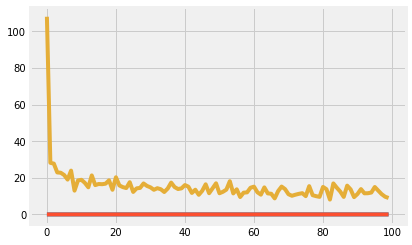

In [38]:
# plot metrics
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.plot(history.history['mape'])
# pyplot.plot(history.history['cosine_proximity'])
plt.show()

In [62]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

16/16 [==============================] - 1s 40ms/step


In [63]:
test_predict

array([[0.22924621],
       [0.23488647],
       [0.26093403],
       [0.25447488],
       [0.25783542],
       [0.26350668],
       [0.2567239 ],
       [0.25697243],
       [0.28078556],
       [0.2690569 ],
       [0.27244383],
       [0.25982523],
       [0.24397965],
       [0.2642119 ],
       [0.25428885],
       [0.257079  ],
       [0.25502288],
       [0.24543779],
       [0.2541124 ],
       [0.2546864 ],
       [0.25410497],
       [0.25475177],
       [0.24874665],
       [0.24308595],
       [0.23586984],
       [0.26539108],
       [0.27681103],
       [0.2812673 ],
       [0.311827  ],
       [0.32171345],
       [0.32108313],
       [0.34263253],
       [0.3525945 ],
       [0.3478584 ],
       [0.35026348],
       [0.37296048],
       [0.38843322],
       [0.38486093],
       [0.4312839 ],
       [0.41447395],
       [0.3913175 ],
       [0.35842893],
       [0.36836615],
       [0.29534113],
       [0.32303244],
       [0.3270925 ],
       [0.32585678],
       [0.362

In [64]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.0014915152213501454

In [65]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.08232350940876193

In [66]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.07013117492139698

In [67]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.11372931728191937

In [68]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)
# accuracy = 100 - mape #Calculate accuracy
# print("The accuracy score is:" + str(accuracy) + "%")

11.37


In [54]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [55]:
test_predict

array([[ 284.38782],
       [ 291.30698],
       [ 323.2608 ],
       [ 315.33707],
       [ 319.4596 ],
       [ 326.4168 ],
       [ 318.09607],
       [ 318.40094],
       [ 347.61368],
       [ 333.22552],
       [ 337.38046],
       [ 321.9006 ],
       [ 302.46204],
       [ 327.28195],
       [ 315.10886],
       [ 318.53168],
       [ 316.0093 ],
       [ 304.25082],
       [ 314.89236],
       [ 315.59653],
       [ 314.88327],
       [ 315.67673],
       [ 308.30997],
       [ 301.3657 ],
       [ 292.51334],
       [ 328.72852],
       [ 342.73795],
       [ 348.20465],
       [ 385.6938 ],
       [ 397.82196],
       [ 397.04874],
       [ 423.48447],
       [ 435.7053 ],
       [ 429.8953 ],
       [ 432.84573],
       [ 460.68927],
       [ 479.67044],
       [ 475.28815],
       [ 532.23755],
       [ 511.61594],
       [ 483.20874],
       [ 442.8627 ],
       [ 455.0532 ],
       [ 365.46973],
       [ 399.44003],
       [ 404.42072],
       [ 402.9048 ],
       [ 447.

In [57]:
test_predict.shape

(505, 1)

In [58]:
targets = test[price_column][window_len+1:]
targets

date
2020-07-10    308.929993
2020-07-13    299.411987
2020-07-14    303.359985
2020-07-15    309.201996
2020-07-16    300.127991
                 ...    
2022-07-06    695.200012
2022-07-07    733.630005
2022-07-08    752.289978
2022-07-11    703.030029
2022-07-12    699.210022
Name: close, Length: 505, dtype: float64

In [59]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2020-07-10    284.387817
2020-07-13    291.306976
2020-07-14    323.260803
2020-07-15    315.337067
2020-07-16    319.459595
                 ...    
2022-07-06    761.355347
2022-07-07    778.245850
2022-07-08    774.138062
2022-07-11    810.941650
2022-07-12    832.002075
Length: 505, dtype: float32

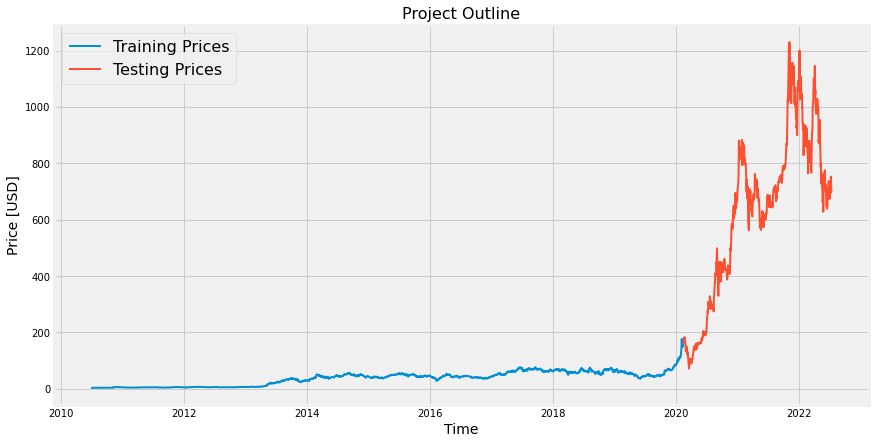

In [60]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

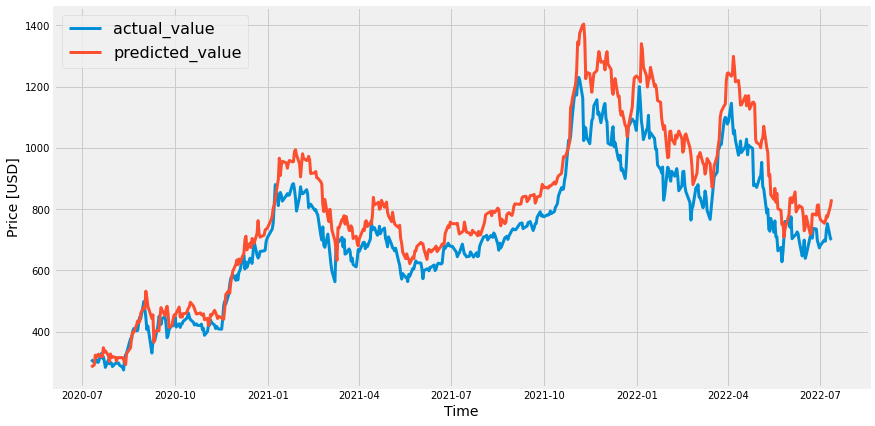

In [61]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [119]:
len(test)

606

In [120]:
length = len(test_scaled)
length

606

In [121]:
#Getting the last 100 days records
fut_inp = test_scaled[length-100:]
fut_inp.shape

(100, 1)

In [122]:
fut_inp

array([[0.75013653],
       [0.71179128],
       [0.69600159],
       [0.66710414],
       [0.62024044],
       [0.65018137],
       [0.65759933],
       [0.70696553],
       [0.70202565],
       [0.71467698],
       [0.68158138],
       [0.68076622],
       [0.65328714],
       [0.66944365],
       [0.69762376],
       [0.68077438],
       [0.64576316],
       [0.62213978],
       [0.65109435],
       [0.68234763],
       [0.70791926],
       [0.73546362],
       [0.74831869],
       [0.80767879],
       [0.81186057],
       [0.82393312],
       [0.82125941],
       [0.88745053],
       [0.89375171],
       [0.88920315],
       [0.87584263],
       [0.8815406 ],
       [0.93115135],
       [0.88697777],
       [0.8498879 ],
       [0.85926226],
       [0.83336455],
       [0.79296512],
       [0.80194822],
       [0.83082125],
       [0.80035865],
       [0.81608311],
       [0.83553291],
       [0.7940004 ],
       [0.81974322],
       [0.81670264],
       [0.81097207],
       [0.711

In [123]:
fut_inp = fut_inp.reshape(1,-1)

In [124]:
fut_inp.shape

(1, 100)

In [125]:
fut_inp

array([[0.75013653, 0.71179128, 0.69600159, 0.66710414, 0.62024044,
        0.65018137, 0.65759933, 0.70696553, 0.70202565, 0.71467698,
        0.68158138, 0.68076622, 0.65328714, 0.66944365, 0.69762376,
        0.68077438, 0.64576316, 0.62213978, 0.65109435, 0.68234763,
        0.70791926, 0.73546362, 0.74831869, 0.80767879, 0.81186057,
        0.82393312, 0.82125941, 0.88745053, 0.89375171, 0.88920315,
        0.87584263, 0.8815406 , 0.93115135, 0.88697777, 0.8498879 ,
        0.85926226, 0.83336455, 0.79296512, 0.80194822, 0.83082125,
        0.80035865, 0.81608311, 0.83553291, 0.7940004 , 0.81974322,
        0.81670264, 0.81097207, 0.71184835, 0.71599754, 0.71273689,
        0.70723455, 0.73346646, 0.73861013, 0.7739637 , 0.70928878,
        0.70306909, 0.63904623, 0.64958627, 0.59575299, 0.59086202,
        0.62476463, 0.58790298, 0.6182596 , 0.57603422, 0.57571629,
        0.53861015, 0.54757694, 0.50947622, 0.5344528 , 0.57433867,
        0.6166456 , 0.61552883, 0.60094557, 0.62

In [126]:
tmp_inp = list(fut_inp)

In [127]:
tmp_inp

[array([0.75013653, 0.71179128, 0.69600159, 0.66710414, 0.62024044,
        0.65018137, 0.65759933, 0.70696553, 0.70202565, 0.71467698,
        0.68158138, 0.68076622, 0.65328714, 0.66944365, 0.69762376,
        0.68077438, 0.64576316, 0.62213978, 0.65109435, 0.68234763,
        0.70791926, 0.73546362, 0.74831869, 0.80767879, 0.81186057,
        0.82393312, 0.82125941, 0.88745053, 0.89375171, 0.88920315,
        0.87584263, 0.8815406 , 0.93115135, 0.88697777, 0.8498879 ,
        0.85926226, 0.83336455, 0.79296512, 0.80194822, 0.83082125,
        0.80035865, 0.81608311, 0.83553291, 0.7940004 , 0.81974322,
        0.81670264, 0.81097207, 0.71184835, 0.71599754, 0.71273689,
        0.70723455, 0.73346646, 0.73861013, 0.7739637 , 0.70928878,
        0.70306909, 0.63904623, 0.64958627, 0.59575299, 0.59086202,
        0.62476463, 0.58790298, 0.6182596 , 0.57603422, 0.57571629,
        0.53861015, 0.54757694, 0.50947622, 0.5344528 , 0.57433867,
        0.6166456 , 0.61552883, 0.60094557, 0.62

In [128]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [129]:
tmp_inp

[0.7501365310742678,
 0.7117912792330112,
 0.6960015947307486,
 0.6671041420977862,
 0.6202404376701245,
 0.6501813718311257,
 0.6575993255688796,
 0.7069655341048884,
 0.7020256540706158,
 0.7146769844719646,
 0.6815813774821546,
 0.6807662154912971,
 0.653287136570807,
 0.6694436529357375,
 0.6976237597560973,
 0.6807743752628256,
 0.6457631579735502,
 0.6221397789665764,
 0.6510943491850761,
 0.6823476313838847,
 0.7079192597764379,
 0.735463615238832,
 0.7483186855978519,
 0.8076787874782322,
 0.8118605725671414,
 0.8239331200214176,
 0.8212594147765885,
 0.8874505284912836,
 0.8937517143773727,
 0.8892031463355151,
 0.875842629893092,
 0.8815406040575664,
 0.9311513505937267,
 0.8869777704037137,
 0.8498878998196955,
 0.8592622627145573,
 0.8333645499617733,
 0.7929651241403594,
 0.8019482247676873,
 0.8308212486261077,
 0.8003586491035712,
 0.8160831059736495,
 0.835532908572962,
 0.7940003953568263,
 0.8197432248858614,
 0.8167026372383211,
 0.8109720745277763,
 0.71184834627850

In [130]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        print("future input is:")
        print(fut_inp)
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

future input is:
[0.71179128 0.69600159 0.66710414 0.62024044 0.65018137 0.65759933
 0.70696553 0.70202565 0.71467698 0.68158138 0.68076622 0.65328714
 0.66944365 0.69762376 0.68077438 0.64576316 0.62213978 0.65109435
 0.68234763 0.70791926 0.73546362 0.74831869 0.80767879 0.81186057
 0.82393312 0.82125941 0.88745053 0.89375171 0.88920315 0.87584263
 0.8815406  0.93115135 0.88697777 0.8498879  0.85926226 0.83336455
 0.79296512 0.80194822 0.83082125 0.80035865 0.81608311 0.83553291
 0.7940004  0.81974322 0.81670264 0.81097207 0.71184835 0.71599754
 0.71273689 0.70723455 0.73346646 0.73861013 0.7739637  0.70928878
 0.70306909 0.63904623 0.64958627 0.59575299 0.59086202 0.62476463
 0.58790298 0.6182596  0.57603422 0.57571629 0.53861015 0.54757694
 0.50947622 0.5344528  0.57433867 0.6166456  0.61552883 0.60094557
 0.62917463 0.5709313  0.58013451 0.58161806 0.58890561 0.58362337
 0.5653393  0.5250051  0.53760747 0.56722232 0.51855714 0.52750765
 0.57709392 0.57477073 0.57228449 0.59829629 

future input is:
[0.68076622 0.65328714 0.66944365 0.69762376 0.68077438 0.64576316
 0.62213978 0.65109435 0.68234763 0.70791926 0.73546362 0.74831869
 0.80767879 0.81186057 0.82393312 0.82125941 0.88745053 0.89375171
 0.88920315 0.87584263 0.8815406  0.93115135 0.88697777 0.8498879
 0.85926226 0.83336455 0.79296512 0.80194822 0.83082125 0.80035865
 0.81608311 0.83553291 0.7940004  0.81974322 0.81670264 0.81097207
 0.71184835 0.71599754 0.71273689 0.70723455 0.73346646 0.73861013
 0.7739637  0.70928878 0.70306909 0.63904623 0.64958627 0.59575299
 0.59086202 0.62476463 0.58790298 0.6182596  0.57603422 0.57571629
 0.53861015 0.54757694 0.50947622 0.5344528  0.57433867 0.6166456
 0.61552883 0.60094557 0.62917463 0.5709313  0.58013451 0.58161806
 0.58890561 0.58362337 0.5653393  0.5250051  0.53760747 0.56722232
 0.51855714 0.52750765 0.57709392 0.57477073 0.57228449 0.59829629
 0.59637252 0.566399   0.55619315 0.54637046 0.55319336 0.56738536
 0.56412471 0.59545138 0.61066228 0.57050745 0.

future input is:
[0.68234763 0.70791926 0.73546362 0.74831869 0.80767879 0.81186057
 0.82393312 0.82125941 0.88745053 0.89375171 0.88920315 0.87584263
 0.8815406  0.93115135 0.88697777 0.8498879  0.85926226 0.83336455
 0.79296512 0.80194822 0.83082125 0.80035865 0.81608311 0.83553291
 0.7940004  0.81974322 0.81670264 0.81097207 0.71184835 0.71599754
 0.71273689 0.70723455 0.73346646 0.73861013 0.7739637  0.70928878
 0.70306909 0.63904623 0.64958627 0.59575299 0.59086202 0.62476463
 0.58790298 0.6182596  0.57603422 0.57571629 0.53861015 0.54757694
 0.50947622 0.5344528  0.57433867 0.6166456  0.61552883 0.60094557
 0.62917463 0.5709313  0.58013451 0.58161806 0.58890561 0.58362337
 0.5653393  0.5250051  0.53760747 0.56722232 0.51855714 0.52750765
 0.57709392 0.57477073 0.57228449 0.59829629 0.59637252 0.566399
 0.55619315 0.54637046 0.55319336 0.56738536 0.56412471 0.59545138
 0.61066228 0.57050745 0.56739352 0.63244754 0.69738108 0.76555085
 0.83674234 0.91267216 0.99529892 1.08597851 1.

future input is:
[0.88745053 0.89375171 0.88920315 0.87584263 0.8815406  0.93115135
 0.88697777 0.8498879  0.85926226 0.83336455 0.79296512 0.80194822
 0.83082125 0.80035865 0.81608311 0.83553291 0.7940004  0.81974322
 0.81670264 0.81097207 0.71184835 0.71599754 0.71273689 0.70723455
 0.73346646 0.73861013 0.7739637  0.70928878 0.70306909 0.63904623
 0.64958627 0.59575299 0.59086202 0.62476463 0.58790298 0.6182596
 0.57603422 0.57571629 0.53861015 0.54757694 0.50947622 0.5344528
 0.57433867 0.6166456  0.61552883 0.60094557 0.62917463 0.5709313
 0.58013451 0.58161806 0.58890561 0.58362337 0.5653393  0.5250051
 0.53760747 0.56722232 0.51855714 0.52750765 0.57709392 0.57477073
 0.57228449 0.59829629 0.59637252 0.566399   0.55619315 0.54637046
 0.55319336 0.56738536 0.56412471 0.59545138 0.61066228 0.57050745
 0.56739352 0.63244754 0.69738108 0.76555085 0.83674234 0.91267216
 0.99529892 1.08597851 1.1852113  1.29265916 1.4072535  1.52731156
 1.65066147 1.7747941  1.89706016 2.01490545 2.12

In [131]:
end_date

'2022-07-12'

In [132]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [133]:
preds = scaler.inverse_transform(lst_output)
preds

array([[ 779.01504213],
       [ 858.67226262],
       [ 942.2995335 ],
       [1029.63369591],
       [1122.78060583],
       [1224.14298648],
       [1335.38417161],
       [1457.11800361],
       [1588.92967274],
       [1729.50828363],
       [1876.78951244],
       [2028.10901261],
       [2180.38872462],
       [2330.37861071],
       [2474.94533264],
       [2611.35654225],
       [2737.50638354],
       [2852.03570195],
       [2954.33204435],
       [3044.43899028],
       [3122.90026004],
       [3190.60031317],
       [3248.60348437],
       [3298.04284117],
       [3340.02776022],
       [3375.6009327 ],
       [3405.69741718],
       [3431.14639446],
       [3452.66473302],
       [3470.86927319]])

In [134]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [135]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [136]:
len(c)

30

In [137]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12     779.015042
2022-07-13     858.672263
2022-07-14     942.299534
2022-07-15    1029.633696
2022-07-18    1122.780606
2022-07-19    1224.142986
2022-07-20    1335.384172
2022-07-21    1457.118004
2022-07-22    1588.929673
2022-07-25    1729.508284
2022-07-26    1876.789512
2022-07-27    2028.109013
2022-07-28    2180.388725
2022-07-29    2330.378611
2022-08-01    2474.945333
2022-08-02    2611.356542
2022-08-03    2737.506384
2022-08-04    2852.035702
2022-08-05    2954.332044
2022-08-08    3044.438990
2022-08-09    3122.900260
2022-08-10    3190.600313
2022-08-11    3248.603484
2022-08-12    3298.042841
2022-08-15    3340.027760
2022-08-16    3375.600933
2022-08-17    3405.697417
2022-08-18    3431.146394
2022-08-19    3452.664733
2022-08-22    3470.869273
Freq: B, dtype: float64

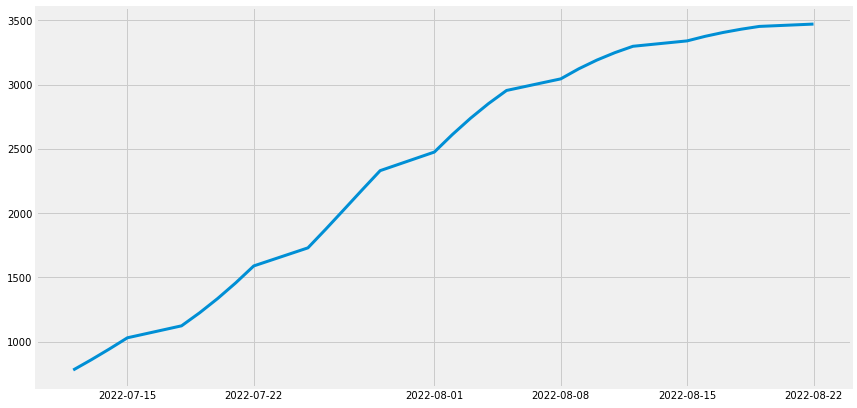

In [138]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

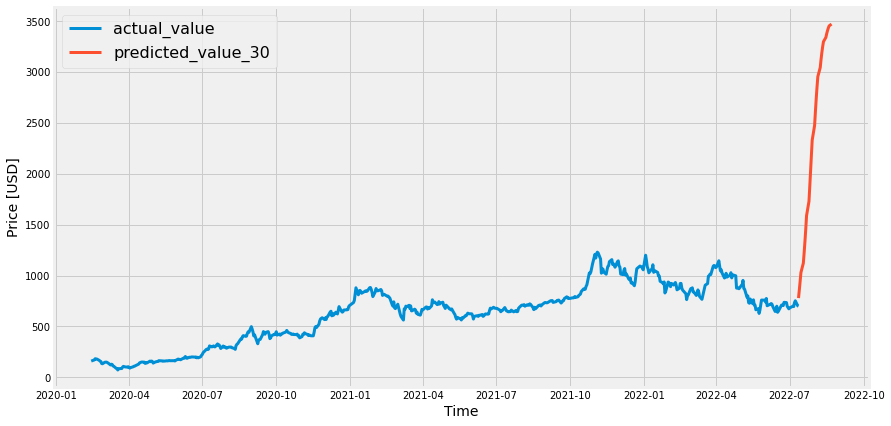

In [139]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)